In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from collections import Counter

In [3]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import optuna
import pickle

e:\raghav\simulator\Anaconda_installer\envs\kagglecompetition\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('completeSpamAssassin.csv')
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [7]:
df.shape

(6046, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [9]:
df.isnull().sum()

Unnamed: 0    0
Body          1
Label         0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df.dropna(inplace=True)

In [12]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [13]:
df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\tarunraghav
[nltk_data]     srikanth\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [17]:
df['char'] = df['Body'].apply(len)
df['words'] = df['Body'].apply(lambda x:len(nltk.word_tokenize(x)))
df['sentences'] = df['Body'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [18]:
df.head()

,Body,Label,char,words,sentences
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4
3,##############################################...,1,2863,690,35
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4


# EDA

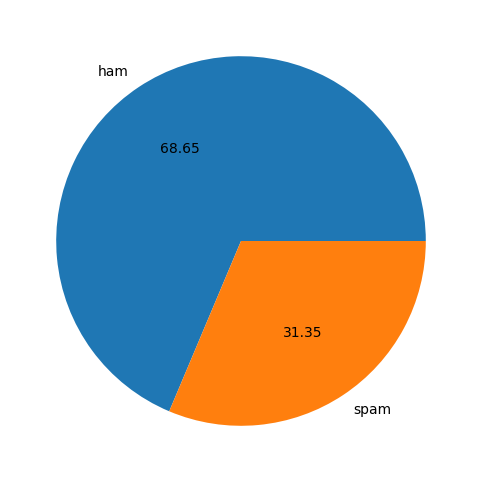

In [19]:
plt.figure(figsize=(12,6))
plt.pie(df['Label'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.show()

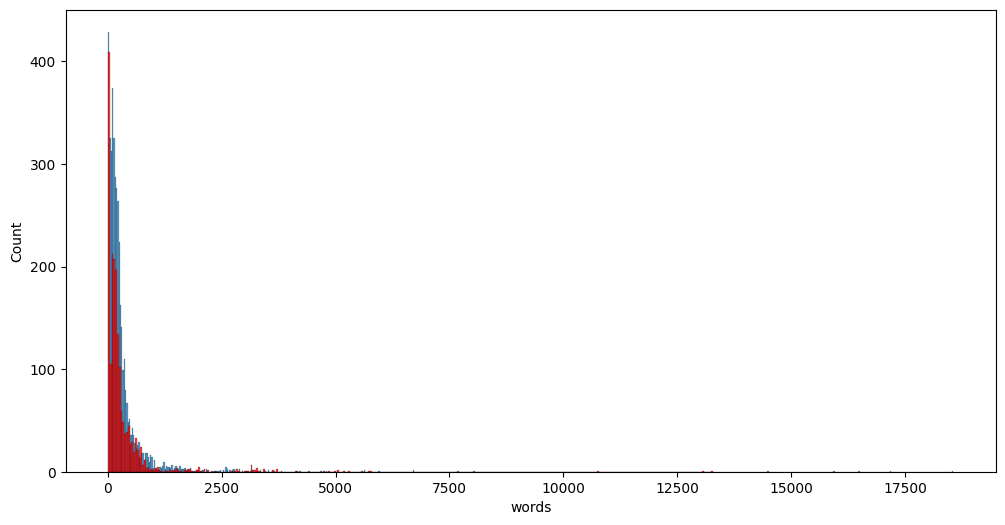

In [21]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['Label'] == 0]['words'])
sns.histplot(df[df['Label'] == 1]['words'], color='red')
plt.show()

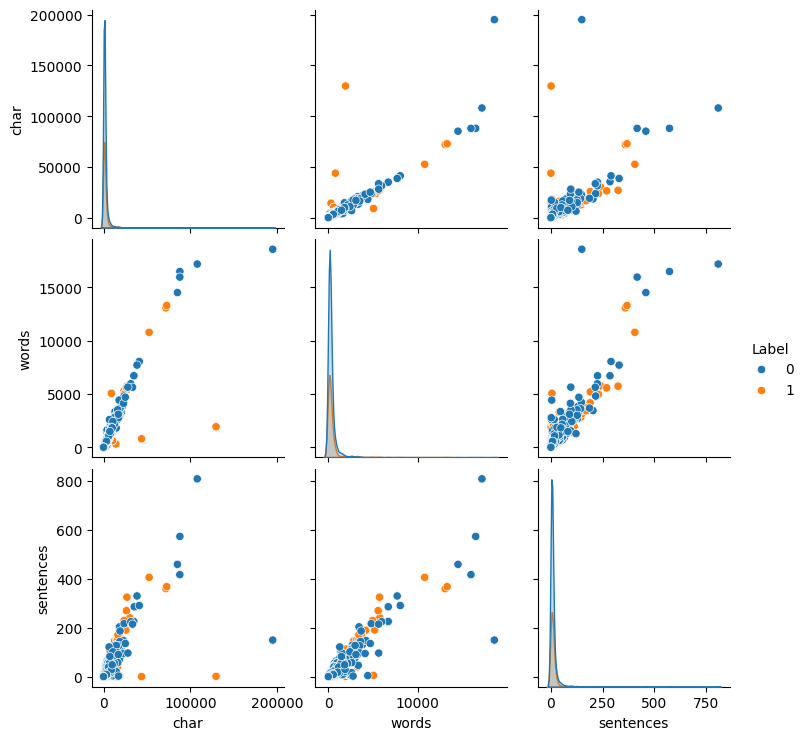

In [22]:
sns.pairplot(df, hue='Label')
plt.show()

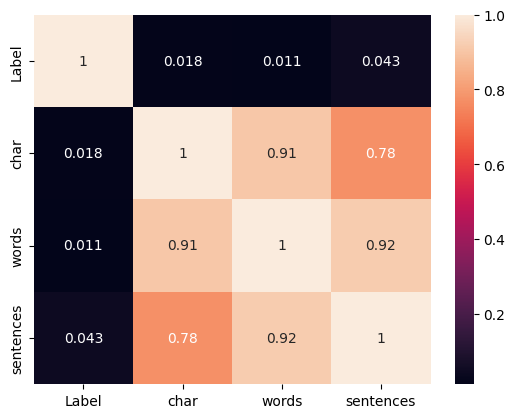

In [26]:
correlate = ['Label', 'char', 'words', 'sentences']

sns.heatmap(df[correlate].corr(), annot=True)
plt.show()

In [27]:
def text_processing(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    stemmer = SnowballStemmer('english')
    for i in text:
        y.append(stemmer.stem(i))

    return " ".join(y)

In [28]:
df['clean_text'] = df['Body'].apply(text_processing)

In [29]:
df.head()

,Body,Label,char,words,sentences,clean_text
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12,save up to 70 on life insur whi spend more tha...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5,1 fight the risk of cancer http slim down guar...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4,1 fight the risk of cancer http slim down guar...
3,##############################################...,1,2863,690,35,adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4,i thought you might like these 1 slim down gua...


In [ ]:
print("hello world !")